[INFO] Loaded 3997 rows from 2010-01-05 to 2025-11-21
[INFO] Train size: 2755, Test size: 1181
[INFO] Metrics:
  auc: 0.5055646452791573
  accuracy: 0.48433530906011857
  sharpe_strat: -2.573382467607431
  hit_rate_strat_vs_ret: 0.3353090601185436
  n_train: 2755
  n_test: 1181
  proba_threshold: 0.55
[OK] Saved predictions → level52_rf_predictions.csv
[OK] Saved feature importances → level52_rf_feature_importance.csv
[OK] Saved metrics → level52_rf_metrics.json


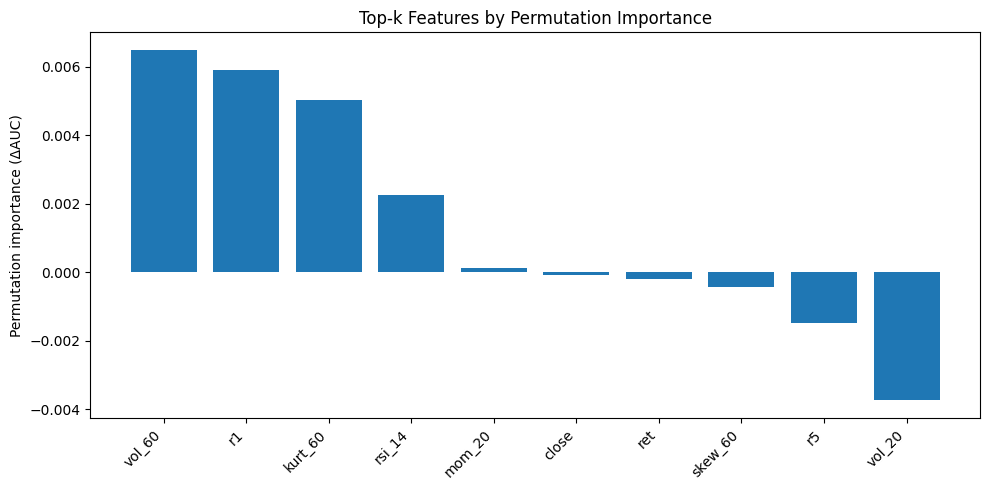

In [2]:
"""
Level-52 — Random Forest Feature-Importance Meta-Label Engine
-------------------------------------------------------------

DSA focus:
    - Sliding windows & rolling features (moving averages, volatility).
    - Hash maps (Python dict) to accumulate feature statistics.
    - Sorting and ranking (turning raw importances into ordered lists).
    - Simple time-based "folds" to see how feature importance drifts.

Quant focus:
    - Binary up/down label on short-horizon returns.
    - RandomForestClassifier as a non-linear meta-model.
    - Probability-threshold strategy: only take trades when the model
      is confident enough (p_up >= threshold).

This script:
    1) Downloads (or synthesizes) daily prices for one symbol.
    2) Builds a small but meaningful feature set (trend, vol, skew).
    3) Creates forward return labels (1 if future return > 0, else 0).
    4) Trains a Random Forest and computes:
           - Gini feature importances (built-in).
           - Simple permutation importances on the test set.
    5) Builds a naive long/flat strategy using probabilities.
    6) Saves:
           - Per-date predictions and strategy returns to CSV.
           - Feature importance table (gini + permutation) to CSV.
           - Summary metrics (AUC, accuracy, Sharpe, hit-rate) to JSON.

Free data:
    - yfinance (SPY).
    - If yfinance fails (no internet / timeout), we fall back
      to a synthetic geometric random walk so the script always runs.
"""

from dataclasses import dataclass
from typing import Dict, List

import json
import math

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score


# ---------------------------- Config ---------------------------- #


@dataclass
class Config:
    symbol: str = "SPY"
    start: str = "2010-01-01"
    label_horizon: int = 1  # days ahead for label
    test_size_frac: float = 0.3
    proba_threshold: float = 0.55
    n_estimators: int = 400
    max_depth: int | None = None
    random_state: int = 42

    out_preds_csv: str = "level52_rf_predictions.csv"
    out_importance_csv: str = "level52_rf_feature_importance.csv"
    out_metrics_json: str = "level52_rf_metrics.json"


# ------------------------- Utility funcs ------------------------ #


def synthetic_price_series(n: int = 2500, start_price: float = 100.0) -> pd.Series:
    """Fallback: simple geometric random walk."""
    rng = np.random.default_rng(42)
    # daily drift 6% annual, vol 20% annual
    mu_daily = 0.06 / 252
    sigma_daily = 0.2 / math.sqrt(252)
    rets = rng.normal(mu_daily, sigma_daily, size=n)
    prices = start_price * np.exp(np.cumsum(rets))
    idx = pd.date_range("2010-01-01", periods=n, freq="B")
    return pd.Series(prices, index=idx, name="close")


def load_price_series(cfg: Config) -> pd.DataFrame:
    """
    Robust loader around yfinance:

    - Tries to download 1 symbol with auto_adjust=True.
    - Handles both Series and DataFrame (multi-column) outputs.
    - Falls back to a synthetic price series if download fails.
    """
    try:
        px = yf.download(
            cfg.symbol,
            start=cfg.start,
            auto_adjust=True,
            progress=False,
        )
    except Exception:
        px = pd.DataFrame()

    if px is None or len(px) == 0:
        print("[WARN] yfinance download failed. Using synthetic price path.")
        close = synthetic_price_series()
    else:
        # yfinance can return:
        # - Series
        # - DataFrame with OHLCV columns
        # - DataFrame with MultiIndex columns (if multiple tickers)
        if isinstance(px, pd.Series):
            close_obj = px
        elif isinstance(px, pd.DataFrame):
            if "Close" in px.columns:
                close_obj = px["Close"]
            else:
                # If MultiIndex, choose first column at level 0, field "Close" if present
                if isinstance(px.columns, pd.MultiIndex):
                    cols = [c for c in px.columns if c[0] == "Close" or c[-1] == "Close"]
                    if len(cols) == 0:
                        close_obj = px.iloc[:, 0]
                    else:
                        close_obj = px[cols[0]]
                else:
                    # Single-level but "Close" missing, pick first numeric column
                    close_obj = px.select_dtypes(include=[np.number]).iloc[:, 0]
        else:
            raise RuntimeError("Unexpected type from yfinance download.")

        # ---- FIX: force 1D array before Series() ----
        close_arr = np.asarray(close_obj, dtype=float).reshape(-1)
        close = pd.Series(close_arr, index=close_obj.index, name="close")

    df = pd.DataFrame({"close": close.astype(float)})
    df["ret"] = np.log(df["close"]).diff()
    df = df.dropna().copy()
    return df


def sharpe_ratio(ret: pd.Series, ann_factor: float = 252.0) -> float:
    """Simple (unbiased) Sharpe estimate."""
    if ret is None or len(ret) < 2:
        return 0.0
    mu = float(ret.mean())
    sigma = float(ret.std(ddof=1))
    if sigma <= 0:
        return 0.0
    return float(mu / sigma * math.sqrt(ann_factor))


def hit_rate(pred: pd.Series, realized: pd.Series) -> float:
    """Fraction of times the sign of pred matches the sign of realized."""
    aligned = pd.concat([pred, realized], axis=1).dropna()
    if aligned.shape[0] == 0:
        return 0.0
    correct = np.sign(aligned.iloc[:, 0]) == np.sign(aligned.iloc[:, 1])
    return float(correct.mean())


# ----------------------- Feature engineering -------------------- #


def compute_rolling_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a compact feature set:

    - r1, r5, r20: 1 / 5 / 20 day log returns.
    - vol_20, vol_60: rolling realized vol.
    - mom_20: 20d momentum.
    - skew_60: rolling skewness (approx).
    - kurt_60: rolling kurtosis (approx).
    - rsi_14: simple RSI-like feature.

    All features are built using rolling windows over 'ret' and 'close'.
    """
    out = df.copy()

    # Past returns
    out["r1"] = out["ret"].shift(1)
    out["r5"] = out["ret"].rolling(5).sum().shift(1)
    out["r20"] = out["ret"].rolling(20).sum().shift(1)

    # Volatility (realized)
    out["vol_20"] = out["ret"].rolling(20).std().shift(1)
    out["vol_60"] = out["ret"].rolling(60).std().shift(1)

    # Momentum over price
    out["mom_20"] = np.log(out["close"] / out["close"].shift(20))

    # Skewness & kurtosis (using moment formulas)
    def _rolling_moments(x: pd.Series) -> pd.Series:
        # Helper for skew/kurt with small arrays
        if x.size < 10:
            return pd.Series({"skew": np.nan, "kurt": np.nan})
        m = float(x.mean())
        s = float(x.std(ddof=1))
        if s <= 0:
            return pd.Series({"skew": np.nan, "kurt": np.nan})
        z = (x - m) / s
        skew = float((z**3).mean())
        kurt = float((z**4).mean())
        return pd.Series({"skew": skew, "kurt": kurt})

    skew_vals: List[float] = []
    kurt_vals: List[float] = []
    vals = out["ret"].values
    n = len(vals)
    window = 60
    for i in range(n):
        if i < window:
            skew_vals.append(np.nan)
            kurt_vals.append(np.nan)
        else:
            seg = pd.Series(vals[i - window : i])
            mk = _rolling_moments(seg)
            skew_vals.append(mk["skew"])
            kurt_vals.append(mk["kurt"])

    out["skew_60"] = pd.Series(skew_vals, index=out.index)
    out["kurt_60"] = pd.Series(kurt_vals, index=out.index)

    # RSI-like oscillator (using running gains/losses)
    def rsi_like(ret: pd.Series, span: int = 14) -> pd.Series:
        up = ret.clip(lower=0.0)
        dn = -ret.clip(upper=0.0)
        avg_up = up.ewm(alpha=1 / span, adjust=False).mean()
        avg_dn = dn.ewm(alpha=1 / span, adjust=False).mean()
        rs = avg_up / (avg_dn + 1e-12)
        rsi = 100.0 - 100.0 / (1.0 + rs)
        return rsi

    out["rsi_14"] = rsi_like(out["ret"])

    out = out.dropna().copy()
    return out


def build_labels(df: pd.DataFrame, horizon: int) -> pd.DataFrame:
    """
    Build binary label:
        y = 1 if future horizon return > 0 else 0

    horizon is in trading days.
    """
    fut_ret = np.log(df["close"].shift(-horizon) / df["close"])
    y = (fut_ret > 0.0).astype(int)
    return pd.DataFrame({"fut_ret": fut_ret, "y": y})


# ----------------------- CV + permutation ----------------------- #


def train_test_split_time(df: pd.DataFrame, test_frac: float) -> tuple:
    """Simple chronological split."""
    n = len(df)
    split_idx = int(n * (1.0 - test_frac))
    train = df.iloc[:split_idx].copy()
    test = df.iloc[split_idx:].copy()
    return train, test


def fit_random_forest(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    cfg: Config,
) -> RandomForestClassifier:
    rf = RandomForestClassifier(
        n_estimators=cfg.n_estimators,
        max_depth=cfg.max_depth,
        min_samples_leaf=5,
        random_state=cfg.random_state,
        n_jobs=-1,
        class_weight="balanced_subsample",
    )
    rf.fit(X_train.values, y_train.values)
    return rf


def permutation_importance(
    model: RandomForestClassifier,
    X: pd.DataFrame,
    y: pd.Series,
    n_rounds: int = 10,
    random_state: int = 42,
) -> Dict[str, float]:
    """
    Simple, library-free permutation importance:

        1) Compute baseline AUC.
        2) For each feature:
             - Shuffle its column (keeping others fixed).
             - Recompute AUC.
             - Importance = baseline - shuffled_AUC (averaged over rounds).
    """
    rng = np.random.default_rng(random_state)
    base_proba = model.predict_proba(X.values)[:, 1]
    try:
        base_auc = roc_auc_score(y.values, base_proba)
    except ValueError:
        base_auc = np.nan

    if not np.isfinite(base_auc):
        base_auc = 0.0

    imp: Dict[str, float] = {c: 0.0 for c in X.columns}

    for col in X.columns:
        deltas: List[float] = []
        col_idx = X.columns.get_loc(col)
        for _ in range(n_rounds):
            X_perm = X.values.copy()
            shuffled = X_perm[:, col_idx].copy()
            rng.shuffle(shuffled)
            X_perm[:, col_idx] = shuffled
            proba_perm = model.predict_proba(X_perm)[:, 1]
            try:
                auc_perm = roc_auc_score(y.values, proba_perm)
            except ValueError:
                auc_perm = np.nan
            if np.isfinite(auc_perm):
                deltas.append(base_auc - auc_perm)
        if len(deltas) > 0:
            imp[col] = float(np.mean(deltas))
        else:
            imp[col] = 0.0

    return imp


# ----------------------------- IO ------------------------------- #


def save_predictions(
    df: pd.DataFrame,
    proba: pd.Series,
    strat_ret: pd.Series,
    cfg: Config,
) -> None:
    out = pd.DataFrame(
        {
            "close": df["close"],
            "ret": df["ret"],
            "p_up": proba,
            "strat_ret": strat_ret,
        }
    )
    out.to_csv(cfg.out_preds_csv, index=True)
    print(f"[OK] Saved predictions → {cfg.out_preds_csv}")


def save_importances(
    gini_imp: Dict[str, float],
    perm_imp: Dict[str, float],
    cfg: Config,
) -> None:
    feats = sorted(gini_imp.keys())
    rows = []
    for f in feats:
        rows.append(
            {
                "feature": f,
                "gini_importance": gini_imp.get(f, 0.0),
                "perm_importance": perm_imp.get(f, 0.0),
            }
        )
    df_imp = pd.DataFrame(rows).sort_values(
        ["gini_importance", "perm_importance"],
        ascending=False,
    )
    df_imp.to_csv(cfg.out_importance_csv, index=False)
    print(f"[OK] Saved feature importances → {cfg.out_importance_csv}")


def save_metrics(
    metrics: Dict[str, float],
    cfg: Config,
) -> None:
    with open(cfg.out_metrics_json, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)
    print(f"[OK] Saved metrics → {cfg.out_metrics_json}")


def plot_feature_importance(
    gini_imp: Dict[str, float],
    perm_imp: Dict[str, float],
    top_k: int = 10,
) -> None:
    """Quick bar plot of top-k features by permutation importance."""
    df_imp = pd.DataFrame(
        {
            "feature": list(perm_imp.keys()),
            "perm": list(perm_imp.values()),
        }
    ).sort_values("perm", ascending=False)

    df_top = df_imp.head(top_k)
    plt.figure(figsize=(10, 5))
    plt.bar(df_top["feature"], df_top["perm"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Permutation importance (ΔAUC)")
    plt.title("Top-k Features by Permutation Importance")
    plt.tight_layout()
    plt.show()


# --------------------------- Pipeline --------------------------- #


def run_pipeline(cfg: Config) -> None:
    # 1) Load data
    df = load_price_series(cfg)
    print(
        f"[INFO] Loaded {len(df)} rows from {df.index.min().date()} "
        f"to {df.index.max().date()}"
    )

    # 2) Features + labels
    feat = compute_rolling_features(df)
    lab = build_labels(feat, cfg.label_horizon)

    # align and drop NaNs
    data = pd.concat([feat, lab], axis=1).dropna().copy()
    y = data["y"].astype(int)
    X = data.drop(columns=["fut_ret", "y"])

    train, test = train_test_split_time(data, cfg.test_size_frac)
    X_train = train[X.columns]
    y_train = train["y"].astype(int)
    X_test = test[X.columns]
    y_test = test["y"].astype(int)

    print(f"[INFO] Train size: {len(train)}, Test size: {len(test)}")

    # 3) Fit RF
    rf = fit_random_forest(X_train, y_train, cfg)

    # 4) Predictions & strategy
    proba_test = pd.Series(
        rf.predict_proba(X_test.values)[:, 1],
        index=X_test.index,
        name="p_up",
    )
    y_pred = (proba_test >= cfg.proba_threshold).astype(int)

    # Strategy: long 1 unit when y_pred == 1, flat otherwise
    strat_ret = pd.Series(0.0, index=proba_test.index, name="strat_ret")
    mask_long = y_pred == 1
    strat_ret.loc[mask_long] = df["ret"].loc[strat_ret.index][mask_long]

    # 5) Metrics
    try:
        auc = roc_auc_score(y_test.values, proba_test.values)
    except ValueError:
        auc = float("nan")

    acc = accuracy_score(y_test.values, y_pred.values)
    sharpe = sharpe_ratio(strat_ret)
    hit = hit_rate(strat_ret, df["ret"].loc[strat_ret.index])

    metrics = {
        "auc": float(auc) if np.isfinite(auc) else float("nan"),
        "accuracy": float(acc),
        "sharpe_strat": float(sharpe),
        "hit_rate_strat_vs_ret": float(hit),
        "n_train": int(len(train)),
        "n_test": int(len(test)),
        "proba_threshold": float(cfg.proba_threshold),
    }

    print("[INFO] Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v}")

    # 6) Importances
    gini_imp = {
        f: float(imp) for f, imp in zip(X.columns, rf.feature_importances_)
    }
    perm_imp = permutation_importance(
        rf, X_test, y_test, n_rounds=10, random_state=cfg.random_state
    )

    # 7) Save outputs
    save_predictions(df.loc[X_test.index], proba_test, strat_ret, cfg)
    save_importances(gini_imp, perm_imp, cfg)
    save_metrics(metrics, cfg)

    # 8) Optional plot (comment out if running headless)
    try:
        plot_feature_importance(gini_imp, perm_imp, top_k=10)
    except Exception:
        pass


# ----------------------------- Main ----------------------------- #


if __name__ == "__main__":
    # Strip Jupyter's extra CLI args when running in notebooks
    import sys

    sys.argv = [sys.argv[0]]
    cfg = Config()
    run_pipeline(cfg)
